# 5. Combine Results

gg-napari-env

In [30]:
import numpy as np
import pandas as pd
import os 

In [31]:
normalization_quantile = 0.001
chosen_OR_nuc_norm_threshold = 0.75
chosen_OR_size_threshold = 400
chosen_OR_border_threshold = 100 
coexpression_nuc_norm_threshold = 0.1
cyto_norm_threshold = 0.2
cyto_nuc_ratio_threshold = 0.5

In [32]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
raw_data_p14 = [d for d in raw_data_dirs if '14' in d]
raw_data_p14

['20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI',
 '20250523 C P14 T U54-647 Lnc4-546 DAPI',
 '20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI',
 '20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI',
 '20250701 F P14 U34-b3-546 Orco-b4-647 DAPI',
 '20250523 B P14 T 9E88-546 Lnc-647 DAPI']

In [49]:
input = 'Orco'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
input_dir = f'../../../RNA-FISH-raw-data/{input}/'
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)

Using 20250701 F P14 U34-b3-546 Orco-b4-647 DAPI as input directory
Found 6 czi files in ../../../RNA-FISH-raw-data/20250701 F P14 U34-b3-546 Orco-b4-647 DAPI/
['20250701 F sample 3 stack.czi', '20250701 F sample 2 stack.czi', '20250701 F sample 1 stack.czi', '20250701 F sample 6 stack.czi', '20250701 F sample 5 stack.czi', '20250701 F sample 4 stack.czi']


In [50]:
channels = ["AF546", "AF647"]
channel_names = ["U34", "Orco"]

In [51]:
"""channels = ["AF546", "AF647"]
channel_names = ["9E89", "9E99"]"""

'channels = ["AF546", "AF647"]\nchannel_names = ["9E89", "9E99"]'

In [52]:
"""channels = ["AF546", "AF647"]
channel_names = ["U34", "Chymotrypsin"]"""

'channels = ["AF546", "AF647"]\nchannel_names = ["U34", "Chymotrypsin"]'

In [53]:
"""channels = ['AF546', 'AF488', 'AF647']
channel_names = ["9E197", "9E198", "9E196"]"""

'channels = [\'AF546\', \'AF488\', \'AF647\']\nchannel_names = ["9E197", "9E198", "9E196"]'

In [54]:
"""channels = ['AF546', 'AF488', 'AF647']
channel_names = ["9E108", "LOC105282603", "9E116"]"""

'channels = [\'AF546\', \'AF488\', \'AF647\']\nchannel_names = ["9E108", "LOC105282603", "9E116"]'

In [55]:
"""channels = ['AF546', 'AF488', 'AF647']
channel_names = ["P1", "PR", "P2"]"""

'channels = [\'AF546\', \'AF488\', \'AF647\']\nchannel_names = ["P1", "PR", "P2"]'

In [56]:
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('with_overlap.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results_individual = pd.read_csv(results_path)
    results_individual.columns = results_individual.columns.str.split('-T').str[0]
    results = pd.concat([results, results_individual], axis=0) 
results = results.reset_index(drop=True)

In [57]:
# Drop rows where "BAD" is in the "image" column 
results = results[~results['image'].str.contains('BAD')]

In [58]:
# ------------------------------------------------------------------
# Parameters you are likely to tweak
# ------------------------------------------------------------------
tail_quantile      = 0.998       # 99.8 th pct  →  0.2 % false-positive target
gate_zscore        = 1.0         # z ≥ 1  ⇒  brighter than 99.8 % of negatives
eps                = 1e-12       # keep denominators > 0
chosen_OR_border_threshold = 100  # as before
chosen_OR_nuc_area_threshold = 400 # as before
# ------------------------------------------------------------------

# ---------------------------------------------------------------
# 1 ▸  Normalise:  “tail-z” per image × channel × compartment
# ---------------------------------------------------------------
for channel in channels:
    nuc_src   = f'{channel}-nucleus-mean'
    cyt_src   = f'{channel}-cyto-mean'
    nuc_z_col = f'{channel}-nuc-norm'
    cyt_z_col = f'{channel}-cyto-norm'
    
    for img in results['image'].unique():
        msk = results['image'].eq(img)

        # ── nucleus ──────────────────────────────────────────────
        nuc_vals = results.loc[msk, nuc_src].values
        med_n    = np.median(nuc_vals)
        sig_n    = np.quantile(nuc_vals, tail_quantile) - med_n
        sig_n    = max(sig_n, eps)
        results.loc[msk, nuc_z_col] = (nuc_vals - med_n) / sig_n

        # ── cytoplasm ────────────────────────────────────────────
        cyt_vals = results.loc[msk, cyt_src].values
        med_c    = np.median(cyt_vals)
        sig_c    = np.quantile(cyt_vals, tail_quantile) - med_c
        sig_c    = max(sig_c, eps)
        results.loc[msk, cyt_z_col] = (cyt_vals - med_c) / sig_c

    # optional: nucleus-to-cyto ratio in the same metric
    results[f'{channel}-cyto-nuc-ratio'] = (
        results[cyt_z_col] / (results[nuc_z_col] + eps)
    )

# ---------------------------------------------------------------
# 2 ▸  Gate:  call “positive cytoplasmic” with the new z-scores
# ---------------------------------------------------------------
for channel in channels:
    z_nuc = f'{channel}-nuc-norm'
    z_cyt = f'{channel}-cyto-norm'
    ratio = f'{channel}-cyto-nuc-ratio'
    
    results[f'{channel}-cytoplasmic'] = (
        (results['border_pxls']  > chosen_OR_border_threshold) &
        (results['nucleus_area'] > chosen_OR_nuc_area_threshold) &
        (results[z_cyt]          >= gate_zscore) &
        (results[z_nuc]          >= gate_zscore)
    )

# ---------------------------------------------------------------
# 3 ▸  Everything downstream: just swap *-norm → *-z columns
# ---------------------------------------------------------------
results_melted = []
for channel in channels:
    subset = results[results[f'{channel}-cytoplasmic']]

    # cytoplasm
    melt_c = subset.melt(
        id_vars=['image','z','z_id','border_pxls','nucleus_area'],
        value_vars=[c + "-cyto-norm" for c in channels],
        var_name='channel', value_name='cyto-norm'
    )
    melt_c['channel'] = melt_c['channel'].str.replace('-cyto-norm','')
    melt_c['cytoplasmic_channel'] = channel

    # nucleus
    melt_n = subset.melt(
        id_vars=['image','z','z_id','border_pxls','nucleus_area'],
        value_vars=[c + "-nuc-norm" for c in channels],
        var_name='channel', value_name='nuc-norm'
    )
    melt_n['channel'] = melt_n['channel'].str.replace('-nuc-norm','')
    melt_n['cytoplasmic_channel'] = channel

    # merge & annotate
    merged = pd.merge(
        melt_c, melt_n,
        on=['image','z','z_id','cytoplasmic_channel','channel',
            'border_pxls','nucleus_area']
    )
    merged['channel_name']     = merged['channel'].map(dict(zip(channels, channel_names)))
    merged['chosen_OR_name']   = merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names))) + " chosen OR"
    results_melted.append(merged)

results_melted = pd.concat(results_melted, axis=0)


In [59]:
results_melted

,image,z,z_id,border_pxls,nucleus_area,channel,cyto-norm,cytoplasmic_channel,nuc-norm,channel_name,chosen_OR_name
0,20250701 F sample 6 stack.czi,32,109,246,661.0,AF546,1.162066,AF546,1.046611,U34,U34 chosen OR
1,20250701 F sample 6 stack.czi,41,97,176,756.0,AF546,1.361285,AF546,1.211351,U34,U34 chosen OR
2,20250701 F sample 6 stack.czi,42,100,168,657.0,AF546,1.701891,AF546,1.176246,U34,U34 chosen OR
3,20250701 F sample 6 stack.czi,43,95,204,478.0,AF546,2.280385,AF546,1.162310,U34,U34 chosen OR
4,20250701 F sample 6 stack.czi,45,80,249,905.0,AF546,1.160801,AF546,1.288923,U34,U34 chosen OR
...,...,...,...,...,...,...,...,...,...,...,...
251,20250701 F sample 2 stack.czi,76,170,172,484.0,AF647,1.096436,AF647,1.058528,Orco,Orco chosen OR
252,20250701 F sample 2 stack.czi,77,55,170,761.0,AF647,1.004846,AF647,1.203435,Orco,Orco chosen OR
253,20250701 F sample 2 stack.czi,78,57,275,852.0,AF647,1.294272,AF647,1.221081,Orco,Orco chosen OR
254,20250701 F sample 2 stack.czi,79,36,225,882.0,AF647,1.103374,AF647,1.081442,Orco,Orco chosen OR


In [60]:
# Save the updated results
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results.to_csv(results_path, index=False)

In [61]:
# Save the melted results 
melted_results_path = os.path.join(results_dir, 'all_results_melted.csv')
results_melted.to_csv(melted_results_path, index=False)

<Axes: xlabel='nuc_norm_log', ylabel='Count'>

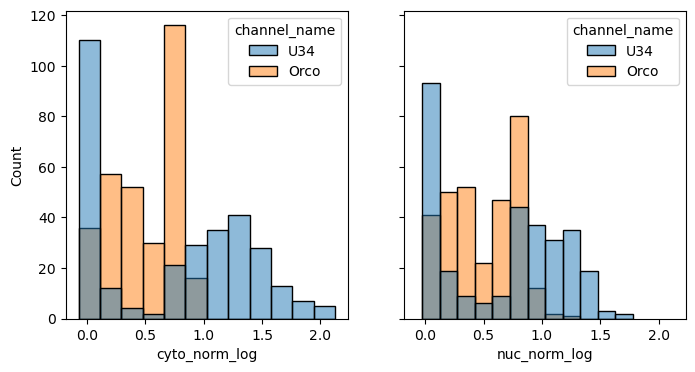

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot density of log-intensities for different channels 
results_melted['cyto_norm_log'] = np.log1p(results_melted['cyto-norm'])
results_melted['nuc_norm_log'] = np.log1p(results_melted['nuc-norm'])
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.histplot(data=results_melted, x='cyto_norm_log', hue='channel_name', fill=True, common_norm=False, alpha=0.5, ax=ax[0])
sns.histplot(data=results_melted, x='nuc_norm_log', hue='channel_name', fill=True, common_norm=False, alpha=0.5, ax=ax[1])